In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd
import datetime

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/dataset

/content/drive/MyDrive/dataset


In [6]:
main_df = pd.read_csv('/content/drive/MyDrive/dataset/HAM10000_metadata.csv')
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


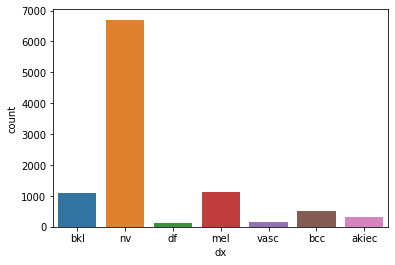

In [7]:
sns.countplot(main_df['dx'])

In [8]:
main_df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

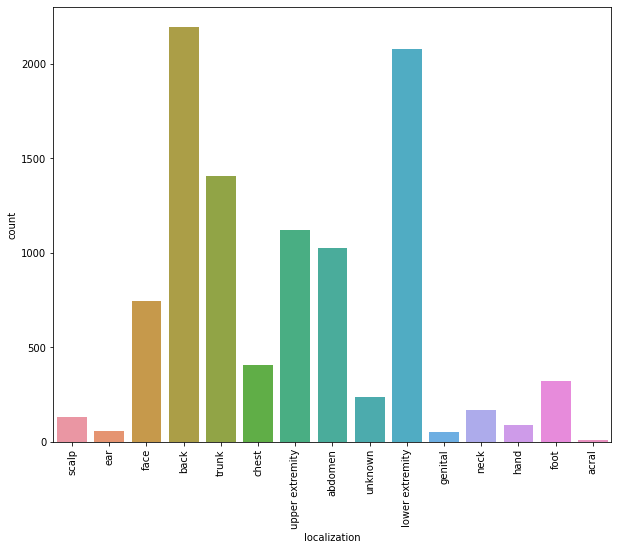

In [9]:
plt.figure(figsize=(10,8))
sns.countplot(main_df['localization'])
plt.xticks(rotation=90)

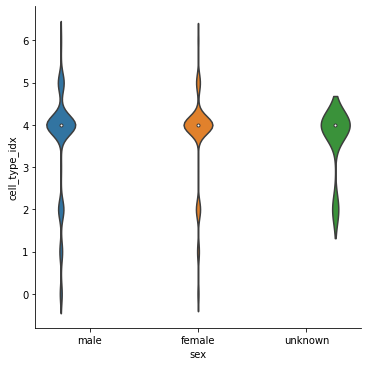

In [10]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_classes_dict = {
    0:'nv',
    1:'mel',
    2:'bkl',
    3:'bcc',
    4:'akiec',
    5:'vasc',
    6:'df'
}

main_df['cell_type'] = main_df['dx'].map(lesion_type_dict)
main_df['cell_type_idx'] = pd.Categorical(main_df['cell_type']).codes
sns.catplot(x="sex", y="cell_type_idx",
                    hue="sex",
                    data=main_df,
                    kind="violin")

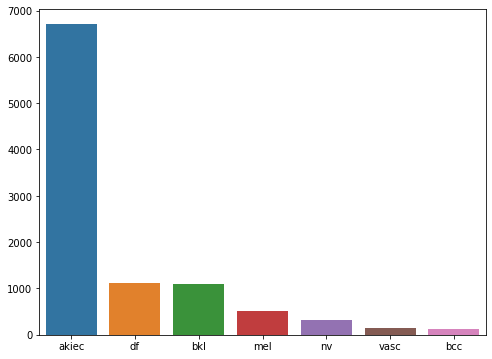

In [11]:
raw_data = pd.read_csv('/content/drive/MyDrive/dataset/hmnist_28_28_RGB.csv')
raw_data = raw_data.sample(frac = 1)
data = raw_data.iloc[:,:-1]
labels = raw_data.iloc[:,-1:]

type_cancer = ['akiec','df','bkl','mel','nv','vasc','bcc']
counts = list(labels.value_counts())
plt.figure(figsize = (8,6))
sns.barplot(x = type_cancer, y = counts)

In [12]:
raw_data = pd.read_csv('/content/drive/MyDrive/dataset/hmnist_28_28_RGB.csv')
raw_data = raw_data.sort_values('label')
raw_data = raw_data.reset_index()

index0 = raw_data[raw_data['label'] == 0].index.values
index1 = raw_data[raw_data['label'] == 1].index.values
index2 = raw_data[raw_data['label'] == 2].index.values
index3 = raw_data[raw_data['label'] == 3].index.values
index5 = raw_data[raw_data['label'] == 5].index.values
index6 = raw_data[raw_data['label'] == 6].index.values

df_index0 = raw_data.iloc[int(min(index0)):int(max(index0)+1)]
df_index1 = raw_data.iloc[int(min(index1)):int(max(index1)+1)]
df_index2 = raw_data.iloc[int(min(index2)):int(max(index2)+1)]
df_index3 = raw_data.iloc[int(min(index3)):int(max(index3)+1)]
df_index5 = raw_data.iloc[int(min(index5)):int(max(index5)+1)]
df_index6 = raw_data.iloc[int(min(index6)):int(max(index6)+1)]


df_index0 = df_index0.append([df_index0]*17, ignore_index = True)
df_index1 = df_index1.append([df_index1]*15, ignore_index = True)
df_index2 = df_index2.append([df_index2]*5, ignore_index = True)
df_index3 = df_index3.append([df_index3]*52, ignore_index = True)
df_index5 = df_index5.append([df_index5]*45, ignore_index = True)
df_index6 = df_index6.append([df_index6]*5, ignore_index = True)

frames = [raw_data, df_index0, df_index1, df_index2, df_index3, df_index5, df_index6]

final_data = pd.concat(frames)
final_data.drop('index', inplace = True, axis = 1)
final_data = final_data.sample(frac = 1)
data = final_data.iloc[:,:-1]
labels = final_data.iloc[:,-1:]

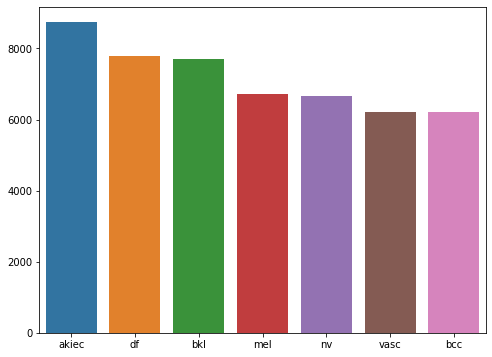

In [13]:
type_cancer = ['akiec','df','bkl','mel','nv','vasc','bcc']
counts = list(labels.value_counts())
plt.figure(figsize = (8,6))
sns.barplot(x = type_cancer, y = counts)

In [14]:
X = np.array(data)
Y = np.array(labels)
# reshaping the data
X = X.reshape(-1,28,28,3)
print("SHAPE OF X IS: ", X.shape)
print("SHAPE OF Y IS: ", Y.shape)

SHAPE OF X IS:  (50024, 28, 28, 3)
SHAPE OF Y IS:  (50024, 1)


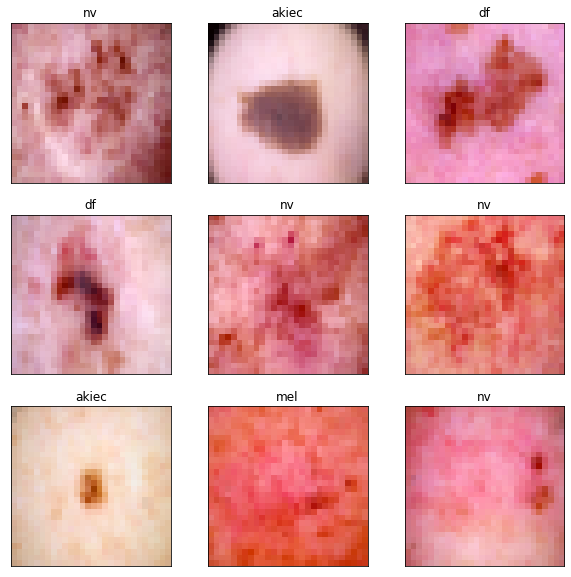

In [15]:
def visualisePlots(X,Y, rows, columns):
    class_dicts = {
        0: 'nv',
        1: 'mel',
        2: 'bkl',
        3: 'bcc',
        4: 'akiec',
        5: 'vasc',
        6: 'df', 
    }
    
    data = []
    target = []

    for i in range(rows*columns):
        data.append(X[i])
        target.append(Y[i])

    width = 10
    height = 10
    fig = plt.figure(figsize=(10,10))
    for i in range(columns*rows):
        temp_img = array_to_img(data[i])
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(temp_img)
        plt.xticks([])
        plt.yticks([])
        plt.title(str(class_dicts[target[i][0]]))
    plt.show()
    
# using the above function

visualisePlots(X,Y, 3,3)


In [16]:
X = (X-np.mean(X))/np.std(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
train_datagen.fit(X_train)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen.fit(X_test)

train_data = train_datagen.flow(X_train, Y_train, batch_size = 64)
test_data = test_datagen.flow(X_test, Y_test, batch_size = 64)

In [17]:
model = Sequential()
model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00075,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8)

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = optimizer,
              metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 64)          3

In [18]:
### TRAINING THE MODEL

start_model = datetime.datetime.now()

history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 64,
                    epochs = 15,
                    callbacks=[learning_rate_reduction])

end_model = datetime.datetime.now()

Epoch 1/15
501/501 [==============================] - 64s 126ms/step - loss: 1.6451 - accuracy: 0.3169 - val_loss: 1.0258 - val_accuracy: 0.5985
Epoch 2/15
501/501 [==============================] - 62s 124ms/step - loss: 0.9008 - accuracy: 0.6523 - val_loss: 0.6361 - val_accuracy: 0.7576
Epoch 3/15
501/501 [==============================] - 63s 125ms/step - loss: 0.5060 - accuracy: 0.8045 - val_loss: 0.3879 - val_accuracy: 0.8482
Epoch 4/15
501/501 [==============================] - 62s 125ms/step - loss: 0.3299 - accuracy: 0.8739 - val_loss: 0.3217 - val_accuracy: 0.8741
Epoch 5/15
501/501 [==============================] - 62s 125ms/step - loss: 0.2413 - accuracy: 0.9080 - val_loss: 0.3114 - val_accuracy: 0.8788
Epoch 6/15
501/501 [==============================] - 63s 125ms/step - loss: 0.1988 - accuracy: 0.9236 - val_loss: 0.1899 - val_accuracy: 0.9277
Epoch 7/15
501/501 [==============================] - 63s 125ms/step - loss: 0.1682 - accuracy: 0.9367 - val_loss: 0.1638 - val_ac

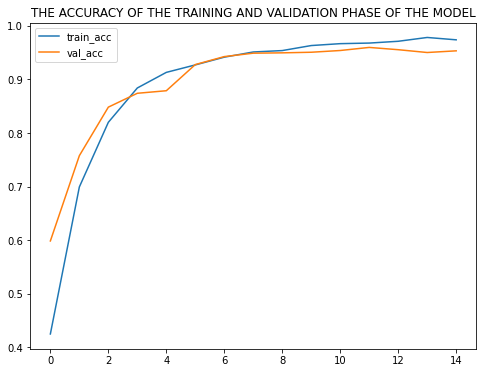

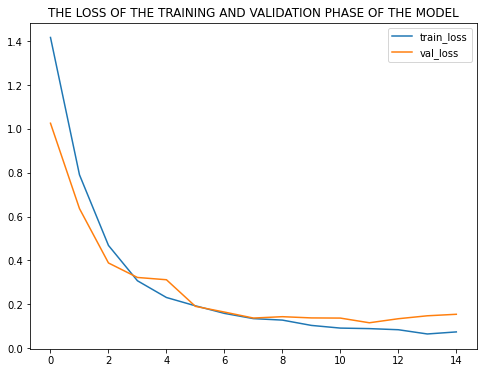

In [19]:
ACC = history.history['accuracy']
VAL_ACC = history.history['val_accuracy']

plt.figure(figsize=(8,6))
plt.title("THE ACCURACY OF THE TRAINING AND VALIDATION PHASE OF THE MODEL")
plt.plot(ACC, label = 'train_acc')
plt.plot(VAL_ACC, label = 'val_acc')
plt.legend()

LOSS = history.history['loss']
VAL_LOSS = history.history['val_loss']

plt.figure(figsize=(8,6))
plt.title("THE LOSS OF THE TRAINING AND VALIDATION PHASE OF THE MODEL")
plt.plot(LOSS, label = 'train_loss')
plt.plot(VAL_LOSS, label = 'val_loss')
plt.legend()


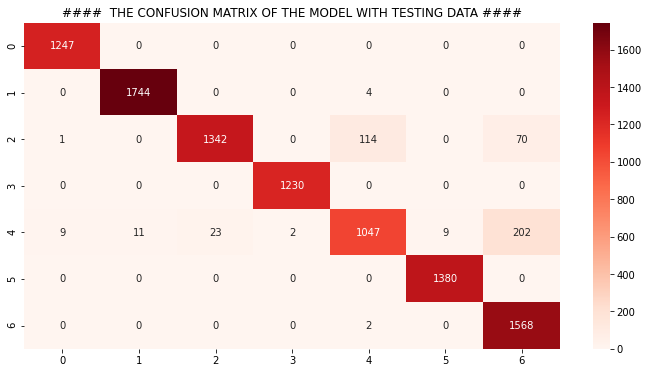

In [20]:
Y_true = np.array(Y_test)

Y_pred = model.predict(X_test)
Y_pred = np.array(list(map(lambda x: np.argmax(x), Y_pred)))

cm1 = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 6))
plt.title('####  THE CONFUSION MATRIX OF THE MODEL WITH TESTING DATA ####')
sns.heatmap(cm1, annot = True, fmt = 'g' ,vmin = 0, cmap = 'Reds')

THE PLOTS TESTING WITH THE MODEL


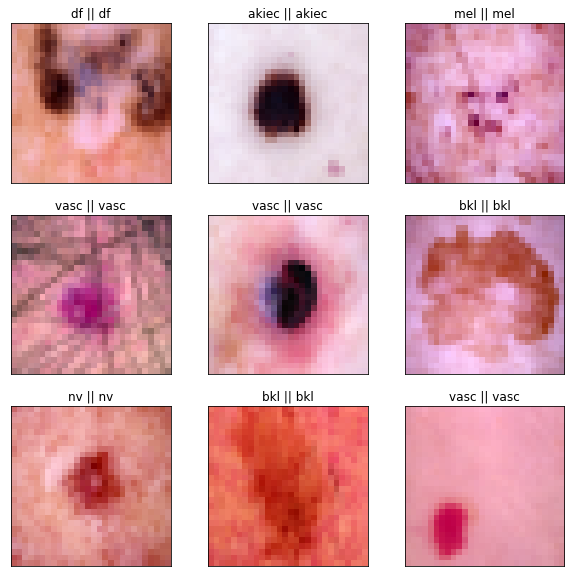

In [23]:
def visualisePlots_test(X,Y, model, rows, columns):
    class_dicts = {
        0: 'nv',
        1: 'mel',
        2: 'bkl',
        3: 'bcc',
        4: 'akiec',
        5: 'vasc',
        6: 'df', 
    }
    
    data = []
    target = []
    
    Y_pred = model.predict(X)
    Y_pred = np.array(list(map(lambda x: np.argmax(x), Y_pred)))

    for i in range(rows*columns):
        data.append(X[i])
        target.append(Y[i])

    width = 10
    height = 10
    fig = plt.figure(figsize=(10,10))
    for i in range(columns*rows):
        temp_img = array_to_img(data[i])
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(temp_img)
        plt.xticks([])
        plt.yticks([])
        plt.title(str(class_dicts[target[i][0]]) + " || " + str(class_dicts[Y_pred[i]]))
    plt.show()
    
# USING THE MODELS AND VISUALISING THEM

print('THE PLOTS TESTING WITH THE MODEL')
visualisePlots_test(X_test,Y_test, model, 3, 3) 


In [24]:
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}

classification_report_model = classification_report(Y_true, Y_pred, target_names=label_mapping.values())
print(classification_report_model)


              precision    recall  f1-score   support

          nv       0.99      1.00      1.00      1247
         mel       0.99      1.00      1.00      1748
         bkl       0.98      0.88      0.93      1527
         bcc       1.00      1.00      1.00      1230
       akiec       0.90      0.80      0.85      1303
        vasc       0.99      1.00      1.00      1380
          df       0.85      1.00      0.92      1570

    accuracy                           0.96     10005
   macro avg       0.96      0.95      0.95     10005
weighted avg       0.96      0.96      0.95     10005



In [25]:
time_model = end_model - start_model
print("TIME TAKEN BY MODEL : ", time_model)


model_acc_test = model.evaluate(X_test, Y_test, verbose=0)[1]
print("TEST ACCURACY OF MODEL: {:.3f}%".format(model_acc_test * 100))

TIME TAKEN BY MODEL :  0:15:40.439038
TEST ACCURACY OF MODEL: 95.532%


In [26]:
model.save_weights("model_v2_weights.h5")